In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score,f1_score,recall_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

# Artificial Neural Network Libraries
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [4]:
data = pd.read_csv('diabetes-dataset.csv')

In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [6]:
data.tail(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0
1998,0,129,110,46,130,67.1,0.319,26,1
1999,2,81,72,15,76,30.1,0.547,25,0


In [7]:
data.shape

(2000, 9)

In [8]:
# The Data Set has 2000 rows and 9 columns

In [9]:
# Created a function to get necessary information from the data set in a dataframe
def get_data_info():
    dataa = pd.DataFrame(index=data.columns)
    dataa['Data_type'] = data.dtypes
    dataa['Total Value'] = data.count()
    dataa['Null_count'] = data.isnull().sum()
    dataa['Unique_count'] = data.nunique()
    return dataa

In [10]:
get_data_info()

,Data_type,Total Value,Null_count,Unique_count
Pregnancies,int64,2000,0,17
Glucose,int64,2000,0,136
BloodPressure,int64,2000,0,47
SkinThickness,int64,2000,0,53
Insulin,int64,2000,0,182
BMI,float64,2000,0,247
DiabetesPedigreeFunction,float64,2000,0,505
Age,int64,2000,0,52
Outcome,int64,2000,0,2


In [11]:
# You can easily see the Total Values, The Total Number of Null Values and the Unique numbers in each column.

In [12]:
#From the above table, it shows that theirr are no NULL Values in the dataset. Let us check for outliers by using 
#Standard Deviation and removing them.

In [13]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


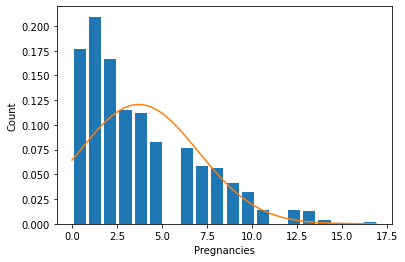

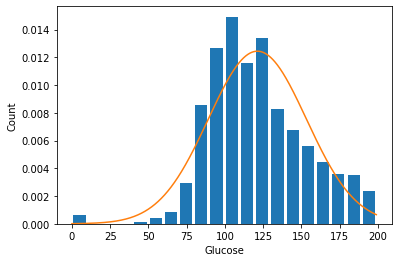

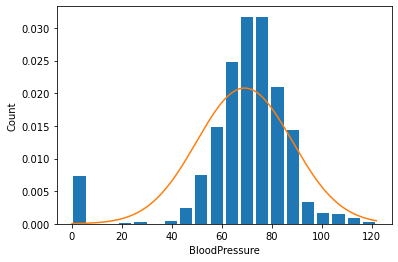

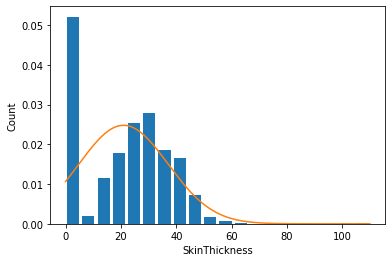

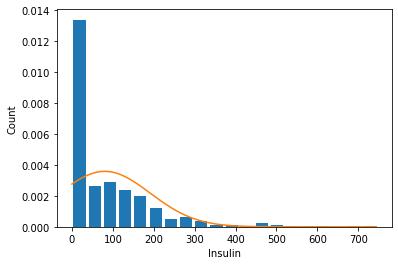

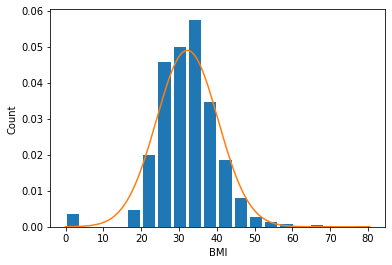

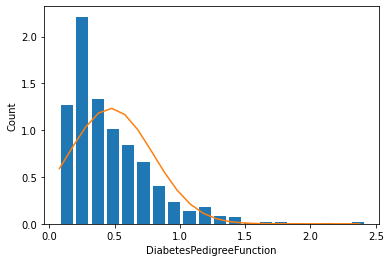

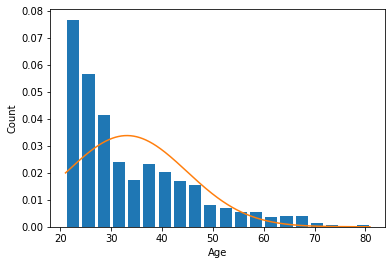

In [14]:
# Let's start by visualizing the distribution of values within each column except the Outcome column which is our target
for i in data.columns:
    if i =='Outcome':
        pass
    else:
        plt.hist(data[i],bins=20,rwidth=0.8,density=True)
        plt.xlabel(i)
        plt.ylabel('Count')
        rng = np.arange(data[i].min(),data[i].max(),0.1)
        plt.plot(rng,norm.pdf(rng,data[i].mean(),data[i].std()))
        plt.show()

In [15]:
#Detect and remove the outliers using the standaard deviation. Any value outside the 3rd range will be dropped as an outlier

for i in data.columns:
    upper_limit = data[i].mean() + (3*data[i].std())
    lower_limit = data[i].mean() - (3*data[i].std())
    data = data[(data[i]<upper_limit) & (data[i]>lower_limit)]
data.shape

(1776, 9)

In [16]:
# All outliers have been removed and all the null values too. So let's Visualize

## DATA VISUALIZATION

In [17]:
#Categorizing my BMI, Age and Glucose Columns into categorical values using range.
#Categories used
#Age: 0-12   :  Children,    BMI: 0-18  : Underweight       GlucoseLevel:   0-89      : Low
#     13-17  :  Teens,            19-24 : Ideal                             90-159    : Normal
#     18-44  :  Adults            25-30 : Overweight                        160-229   : High
#     45-59  :  Mid Adults        30-50 : Obesity                           230-500   : Very High
#     60-150 :  Elderly

data['bmi_cat'] = pd.cut(data['BMI'], bins = [0, 19, 25,30,50], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
data['age_cat'] = pd.cut(data['Age'], bins = [0,13,18, 45,60,150], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
data['glucose_cat'] = pd.cut(data['Glucose'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

In [18]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,bmi_cat,age_cat,glucose_cat
0,2,138,62,35,0,33.6,0.127,47,1,Obesity,Mid Adults,Normal
1,0,84,82,31,125,38.2,0.233,23,0,Obesity,Adults,Low
3,0,135,68,42,250,42.3,0.365,24,1,Obesity,Adults,Normal
5,0,173,78,32,265,46.5,1.159,58,0,Obesity,Mid Adults,High
6,4,99,72,17,0,25.6,0.294,28,0,Overweight,Adults,Normal


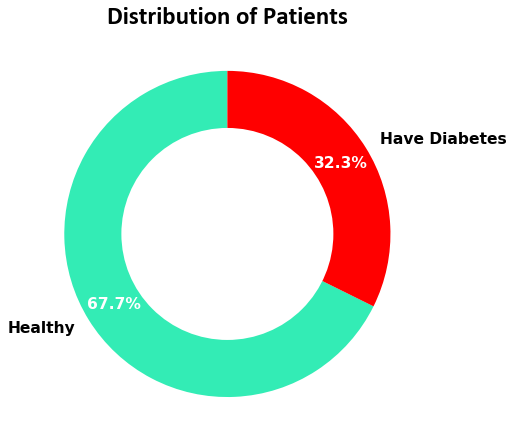

In [19]:
palette2 = ['#33ECB5','#ff0000']

colors = ('#E2F11C','#E3460A')
plt.figure(figsize=(10,7.5))
label = ['Healthy','Have Diabetes']
patches, texts, pcts = plt.pie(data.Outcome.value_counts(),
                               labels=label,
                               colors=[palette2[0],'#ff0000'],
                               pctdistance=0.82,
                               shadow=False,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 15.5,
                                          'weight': 'bold'
                                          })
plt.setp(pcts, color='white')

hfont = {'fontname':'calibri', 'weight': 'bold'}
plt.title('Distribution of Patients', size=25, **hfont)

centre_circle = plt.Circle((0,0),0.65,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.savefig("Visualizations\DistributionofPatients.png")
plt.show()
# plt.text(0.5,0.5,'Percentage of People leaving with Stroke', horizontalalignment='center',verticalalignment='center',size=18, alpha = 0.6)

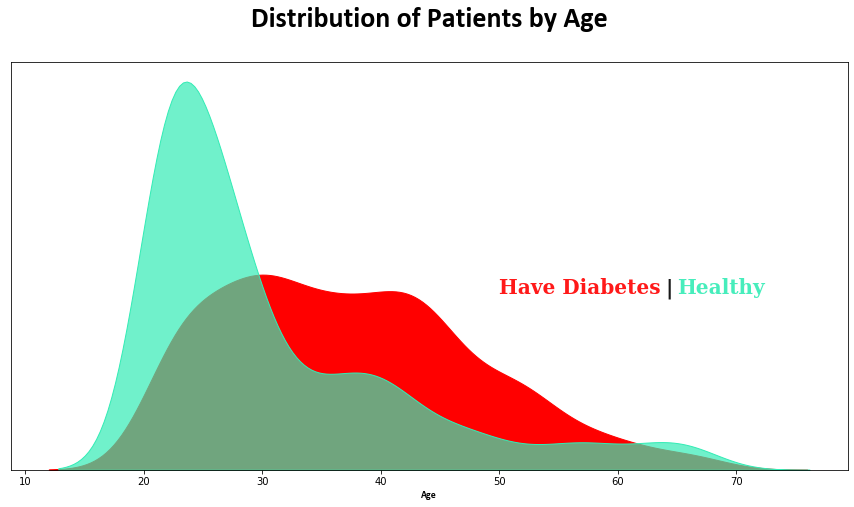

In [20]:
fig = plt.figure(figsize=(15, 7.5))
ax = fig.add_subplot(111)
plt.title('Distribution of Patients by Age\n', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(50, 0.03, 'Have Diabetes', {'font': 'Serif',
                             'size': '20',
                             'weight': 'bold',
                             'color': '#ff0000'}, alpha=0.9)

ax.text(64, 0.03, '|', {'font': 'Serif',
                       'size': '20',
                       'weight': 'bold',
                       'color': 'black'}, alpha=0.9)

ax.text(65, 0.03, 'Healthy', {'font': 'Serif',
                              'size': '20',
                              'weight': 'bold',
                              'color': palette2[0]}, alpha=0.9)

sns.kdeplot(data=data[data.Outcome == 1],
            x='Age', shade=True, ax=ax, color='#ff0000', alpha=1)
sns.kdeplot(data=data[data.Outcome == 0],
            x='Age', shade=True, ax=ax, color=palette2[0], alpha=0.7)
plt.xlabel('Age', **hfont)
plt.savefig("Visualizations\DistributionofPatientsbyage.png")
plt.show()

In [21]:
breakdownbyage = data.groupby(['age_cat','Outcome']).size().reset_index(name ='Count')
breakdownbyage

,age_cat,Outcome,Count
0,Children,0,0
1,Children,1,0
2,Teens,0,0
3,Teens,1,0
4,Adults,0,1063
5,Adults,1,452
6,Mid Adults,0,93
7,Mid Adults,1,106
8,Elderly,0,46
9,Elderly,1,16


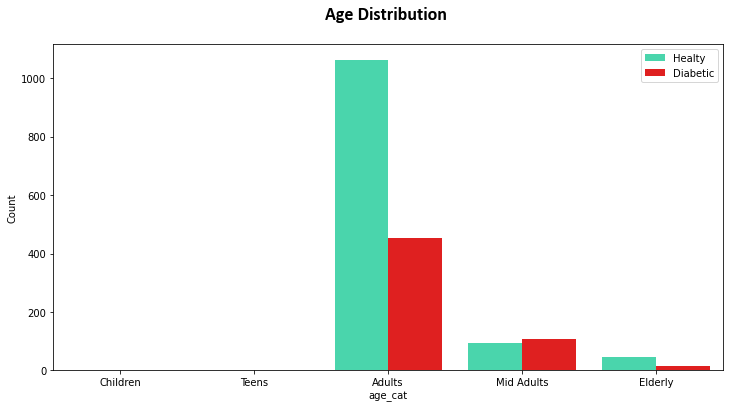

In [22]:
plt.figure(figsize = (12,6))
labels=["Healty","Diabetic"]
g = sns.barplot(x ='age_cat', y = 'Count', hue = 'Outcome', data = breakdownbyage, palette = palette2)
h, l = g.get_legend_handles_labels()
g.legend(h, labels, title="")
plt.title("Age Distribution \n",size=18, **hfont)
plt.savefig("Visualizations\AgeDistribution.png")
plt.show()

In [23]:
breakdownbybmi = data.groupby(['bmi_cat','Outcome']).size().reset_index(name ='Count')
breakdownbybmi

,bmi_cat,Outcome,Count
0,Underweight,0,10
1,Underweight,1,0
2,Ideal,0,225
3,Ideal,1,18
4,Overweight,0,340
5,Overweight,1,103
6,Obesity,0,625
7,Obesity,1,445


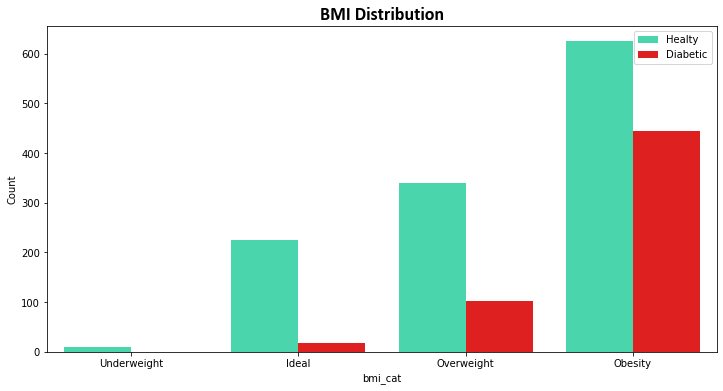

In [24]:
plt.figure(figsize = (12,6))
labels=["Healty","Diabetic"]
g = sns.barplot(x ='bmi_cat', y = 'Count', hue = 'Outcome', data = breakdownbybmi, palette = palette2)
h, l = g.get_legend_handles_labels()
g.legend(h, labels, title="")
plt.title("BMI Distribution",size=18, **hfont)
plt.savefig("Visualizations\BMIDistribution.png")
plt.show()

In [25]:
# From the above, it shows that BMI determines weather a patient has Diabetics or not.

In [26]:
breakdownbyglucose = data.groupby(['glucose_cat','Outcome']).size().reset_index(name ='Count')
breakdownbyglucose

,glucose_cat,Outcome,Count
0,Low,0,251
1,Low,1,12
2,Normal,0,904
3,Normal,1,388
4,High,0,47
5,High,1,174
6,Very High,0,0
7,Very High,1,0


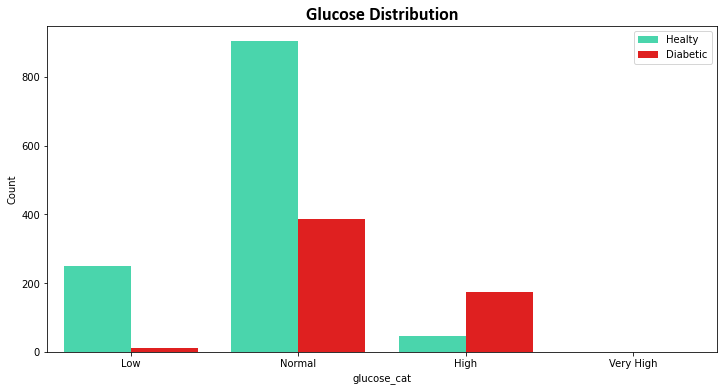

In [27]:
plt.figure(figsize = (12,6))
labels=["Healty","Diabetic"]
g = sns.barplot(x ='glucose_cat', y = 'Count', hue = 'Outcome', data = breakdownbyglucose, palette = palette2)
h, l = g.get_legend_handles_labels()
g.legend(h, labels, title="")
plt.title("Glucose Distribution",size=18, **hfont)
plt.savefig("Visualizations\GlucoseDistribution.png")
plt.show()

In [28]:
breakdownofpregnancies = data.groupby(['Pregnancies','Outcome']).size().reset_index(name ='Count')
breakdownofpregnancies.head()

,Pregnancies,Outcome,Count
0,0,0,180
1,0,1,67
2,1,0,261
3,1,1,67
4,2,0,205


In [29]:
breakdownofpregnanciesconfirm = breakdownofpregnancies[breakdownofpregnancies['Outcome'] == 1]
breakdownofpregnancieshealthy = breakdownofpregnancies[breakdownofpregnancies['Outcome'] == 0]
breakdownofpregnanciesconfirm,breakdownofpregnancieshealthy

(    Pregnancies  Outcome  Count
 1             0        1     67
 3             1        1     67
 5             2        1     41
 7             3        1     61
 9             4        1     57
 11            5        1     49
 13            6        1     41
 15            7        1     53
 17            8        1     43
 19            9        1     42
 21           10        1     19
 23           11        1     13
 25           12        1     10
 27           13        1     11,
     Pregnancies  Outcome  Count
 0             0        0    180
 2             1        0    261
 4             2        0    205
 6             3        0    112
 8             4        0    117
 10            5        0     81
 12            6        0     78
 14            7        0     40
 16            8        0     41
 18            9        0     25
 20           10        0     32
 22           11        0      9
 24           12        0     13
 26           13        0      8)

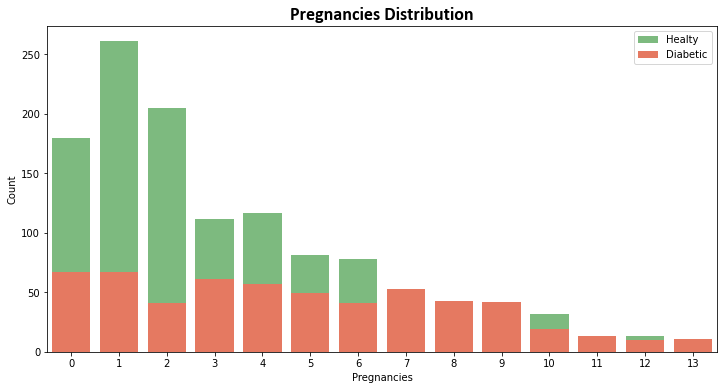

In [30]:
plt.figure(figsize = (12,6))
labels=["Healty","Diabetic"]
g = sns.barplot(x ='Pregnancies', y = 'Count', hue = 'Outcome', data = breakdownofpregnancieshealthy, palette = 'Greens')
g = sns.barplot(x ='Pregnancies', y = 'Count', hue = 'Outcome', data = breakdownofpregnanciesconfirm, palette = 'Reds_r')
h, l = g.get_legend_handles_labels()
g.legend(h, labels, title="")
plt.title("Pregnancies Distribution",size=18, **hfont)
plt.savefig("Visualizations\PregnanciesDistribution.png")
plt.show()

## FEATURE SELECTION

In [31]:
get_data_info()

,Data_type,Total Value,Null_count,Unique_count
Pregnancies,int64,1776,0,14
Glucose,int64,1776,0,131
BloodPressure,int64,1776,0,45
SkinThickness,int64,1776,0,50
Insulin,int64,1776,0,163
BMI,float64,1776,0,231
DiabetesPedigreeFunction,float64,1776,0,458
Age,int64,1776,0,48
Outcome,int64,1776,0,2
bmi_cat,category,1766,10,4


In [32]:
X = data.drop(['bmi_cat','age_cat','glucose_cat','Outcome'],axis='columns')
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35,0,33.6,0.127,47
1,0,84,82,31,125,38.2,0.233,23
3,0,135,68,42,250,42.3,0.365,24
5,0,173,78,32,265,46.5,1.159,58
6,4,99,72,17,0,25.6,0.294,28
...,...,...,...,...,...,...,...,...
1994,1,79,60,42,48,43.5,0.678,23
1995,2,75,64,24,55,29.7,0.370,33
1996,8,179,72,42,130,32.7,0.719,36
1997,6,85,78,0,0,31.2,0.382,42


In [33]:
y = data.Outcome

### HYPERPARAMETER TUNING

In [34]:
# We do this to get the best algorithm and the bestparameters to use for our dataset

In [35]:
#Python Dictionary with 3 supervised models and parameters to choose the best Models and Parameters to use.

models = {
    'Random_forest':{
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,100],
            'n_jobs': [1,10,20],
            'random_state': [1,2,10]
        }
    },
    'Logistic_regression' :{
        'model' : LogisticRegression(),
        'params': {
            'C': [1,5,10],
            'solver':['liblinear','saga'],
            'multi_class':['auto'],
            'random_state': [1,2,10],
            'penalty': ['l1','l2','elasticnet','none']
        }
    },
    'K_Nearest_Neighbour' :{
        'model' : KNeighborsClassifier(),
        'params' :{
            'n_neighbors': [1,5,10],
            'algorithm': ["auto", "brute", "kd_tree", "ball_tree"],
            'weights': ['uniform','distance'],
            'n_jobs' : [1,10,20]
        }
    },
   
}

In [36]:
scores = []

for modelName,mp in models.items():
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)
    sm = SMOTE(random_state=0)
    X_train,y_train = sm.fit_resample(X_train,y_train)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    rs = GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False)
    rs.fit(X_train,y_train)
    scores.append({
        'Model': modelName,
        'Best_Score': rs.best_score_,
        'Best_Parameters':rs.best_params_
    })

In [37]:
pd.options.display.max_colwidth = 200
scoresdf = pd.DataFrame(scores,columns=['Model','Best_Score','Best_Parameters'])
scoresdf.sort_values(by='Best_Score',ascending=False, inplace=True)
scoresdf

,Model,Best_Score,Best_Parameters
0,Random_forest,0.958896,"{'n_estimators': 100, 'n_jobs': 1, 'random_state': 1}"
2,K_Nearest_Neighbour,0.956297,"{'algorithm': 'auto', 'n_jobs': 1, 'n_neighbors': 1, 'weights': 'uniform'}"
1,Logistic_regression,0.745586,"{'C': 1, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear'}"


## 1. RANDOM FOREST

In [38]:
#Split X and y into train and test data using the sklearn library train_test_split
# Split proportion is 80% train data and 20% test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [39]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1420, 8), (356, 8), (1420,), (356,))

In [40]:
# There is an imbalance in the dataset, so we need to handle the data by calling the library SMOTE, it helps us deal with
# the inbalance in the dataset. 
# Creating an object of SMOTE
sm = SMOTE(random_state=0)

# So we call SMOTE on our X_train and y_train
X_train,y_train = sm.fit_resample(X_train,y_train)

In [41]:
# We scale our data using the StandardScaler
# Create an object of StandardScaler
sc = StandardScaler()
# Call fit_transform on the X_train alone and call transform on X_test. 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

In [42]:
# Create a object of our model Random Forest
model = RandomForestClassifier(n_estimators= 100,n_jobs= 1,random_state= 2)
# Call a fit method on your model with your X_train and y_train
model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=1, random_state=2)

In [43]:
# Get Model Score 
score = model.score(X_test,y_test)
score

0.9831460674157303

In [44]:
# Get Predicted Value
prediction = model.predict(X_test)
prediction

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,

In [45]:
# Get Model Precition Score
model_precision = precision_score(y_test,prediction)
model_precision

0.9658119658119658

In [46]:
recall = recall_score(y_test,prediction)
recall

0.9826086956521739

In [47]:
F1 = f1_score(y_test,prediction)
F1

0.9741379310344828

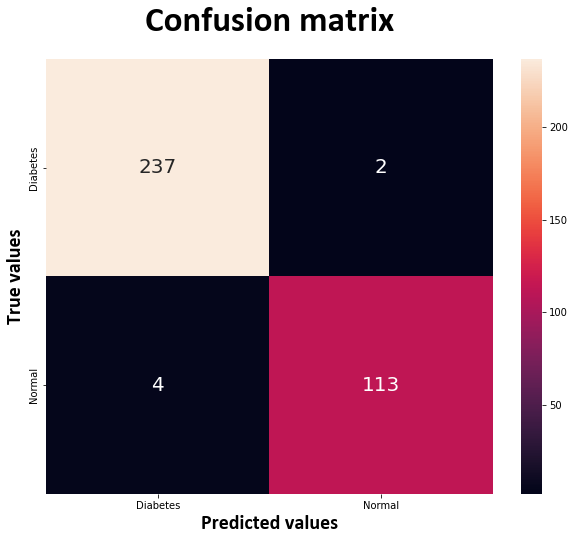

In [48]:
# Confusion Matrics
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(matrix, index = ['Diabetes', 'Normal'],
                            columns = ['Diabetes', 'Normal'])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm,
            annot=True,
            fmt='.5g',
            annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.savefig("Visualizations\RandomForestConfusionMetrics.png")
plt.show()

In [49]:
modelResultsRT = ({
    'Model Name': 'Random Forest',
    'Model Score': score*100,
    'F1 Score': F1 * 100,
    'Precision Score': model_precision * 100
})

## 2. K Nearest Neighbour

In [50]:
#Split X and y into train and test data using the sklearn library train_test_split
# Split proportion is 80% train data and 20% test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [51]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1420, 8), (356, 8), (1420,), (356,))

In [52]:
# There is an imbalance in the dataset, so we need to handle the data by calling the library SMOTE, it helps us deal with
# the inbalance in the dataset. 
# Creating an object of SMOTE
sm = SMOTE(random_state=0)

# So we call SMOTE on our X_train and y_train
X_train,y_train = sm.fit_resample(X_train,y_train)

In [53]:
# We scale our data using the StandardScaler
# Create an object of StandardScaler
sc = StandardScaler()
# Call fit_transform on the X_train alone and call transform on X_test. 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

In [54]:
# Create a object of our model Random Forest
model = KNeighborsClassifier(algorithm='auto',n_jobs= 1,n_neighbors= 10,weights='distance')
# Call a fit method on your model with your X_train and y_train
model.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=1, n_neighbors=10, weights='distance')

In [55]:
# Get Model Score 
score = model.score(X_test,y_test)
score

0.9747191011235955

In [56]:
# Get Predicted Value
prediction = model.predict(X_test)
prediction

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,

In [57]:
# Get Model Precition Score
model_precision = precision_score(y_test,prediction)
model_precision

0.9416666666666667

In [58]:
recall = recall_score(y_test,prediction)
recall

0.9826086956521739

In [59]:
F1 = f1_score(y_test,prediction)
F1

0.9617021276595745

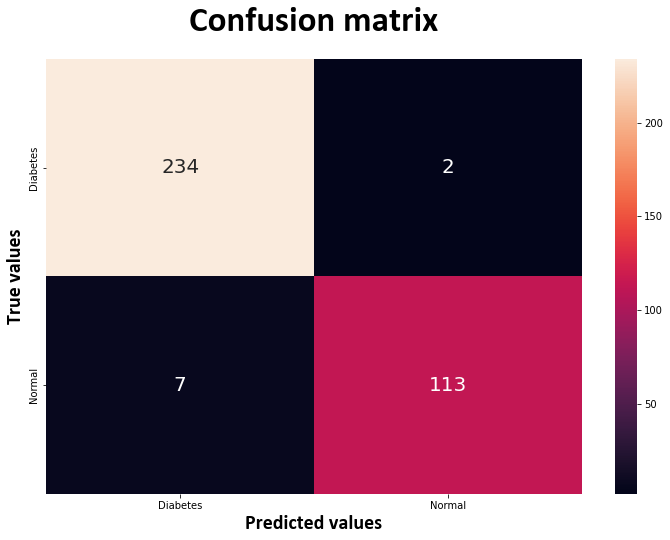

In [60]:
# Confusion Matrics
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(matrix, index = ['Diabetes', 'Normal'],
                            columns = ['Diabetes', 'Normal'])
plt.figure(figsize = (12,8))
sns.heatmap(df_cm,
            annot=True,
            fmt='.5g',
            annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.savefig("Visualizations\KNNConfusionMetrics.png")
plt.show()

In [61]:
modelResultsKN = ({
    'Model Name': 'KNN',
    'Model Score': score*100,
    'F1 Score': F1 * 100,
    'Precision Score': model_precision * 100
})

## 3. Logistic Regression

In [62]:
#Split X and y into train and test data using the sklearn library train_test_split
# Split proportion is 80% train data and 20% test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [63]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1420, 8), (356, 8), (1420,), (356,))

In [64]:
# There is an imbalance in the dataset, so we need to handle the data by calling the library SMOTE, it helps us deal with
# the inbalance in the dataset. 
# Creating an object of SMOTE
sm = SMOTE(random_state=0)

# So we call SMOTE on our X_train and y_train
X_train,y_train = sm.fit_resample(X_train,y_train)

In [65]:
# We scale our data using the StandardScaler
# Create an object of StandardScaler
sc = StandardScaler()
# Call fit_transform on the X_train alone and call transform on X_test. 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

In [66]:
# Create a object of our model
model = LogisticRegression(C= 1,multi_class= 'auto',penalty='none',random_state=1,solver='saga')
# Call a fit method on your model with your X_train and y_train
model.fit(X_train,y_train)

LogisticRegression(C=1, penalty='none', random_state=1, solver='saga')

In [67]:
# Get Model Score 
score = model.score(X_test,y_test)
score

0.7780898876404494

In [68]:
# Get Predicted Value
prediction = model.predict(X_test)
prediction

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,

In [69]:
# Get Model Precition Score
model_precision = precision_score(y_test,prediction)
model_precision

0.6304347826086957

In [70]:
recall = recall_score(y_test,prediction)
recall

0.7565217391304347

In [71]:
F1 = f1_score(y_test,prediction)
F1

0.6877470355731226

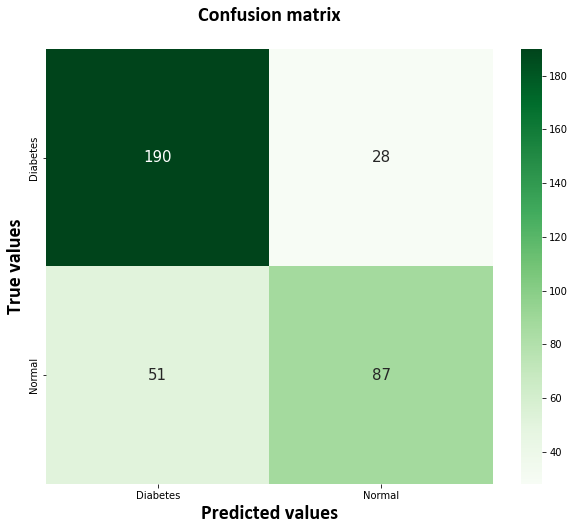

In [72]:
# Confusion Matrics
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_pred, y_test)

cm = pd.DataFrame(matrix, index = ['Diabetes', 'Normal'],
                            columns = ['Diabetes', 'Normal'])
plt.figure(figsize = (10,8))
sns.heatmap(cm,
            annot=True,
            cmap='Greens',
            fmt='.5g',
            annot_kws={"size": 15}).set_title('Confusion matrix', fontsize = 20, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.savefig("Visualizations\LogisticRegressionConfusuinMetrics.png")
plt.show()

In [73]:
modelResultsLR = ({
    'Model Name': 'Logistic Regression',
    'Model Score': score*100,
    'F1 Score': F1 * 100,
    'Precision Score': model_precision * 100
})

## ARTIFICIAL NEURAL NETWORK

In [74]:
sm = SMOTE(random_state=0)

X, y = sm.fit_resample(X, y)

y = keras.utils.to_categorical(y, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=2,stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    keras.layers.Flatten(input_dim=X_train.shape[1]),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train,batch_size=30, epochs=150,validation_data=(X_test, y_test),verbose=0)

16/16 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9771
Neural Network score     ========>>> 0.977


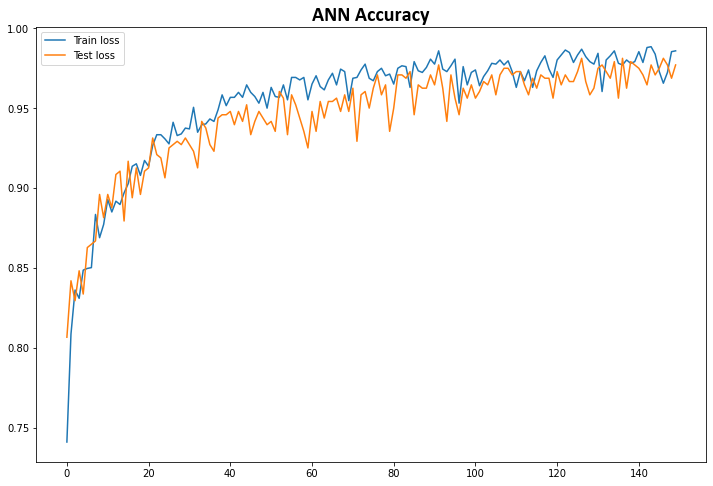

In [75]:
## Plot History
fig = plt.figure(figsize=(12, 8))
plt.title('ANN Accuracy', size=20, **hfont)
plt.plot(history.history['accuracy'], label="Train loss")
plt.plot(history.history['val_accuracy'], label="Test loss")
plt.legend()

model.evaluate(X_test,y_test)
score = np.round(model.evaluate(X_test, y_test, verbose=0)[1], 3)
print(f'Neural Network score     ========>>> {score}')
models_resultsANN = ({
    'Model Name': 'Artificial Neural Network',
    'Model Score': score * 100
})
plt.savefig("Visualizations\ANN ACCURACY.png")

In [76]:
myalgorithms = {
    'Logistic Regression':modelResultsLR,
    'Random Forest Classifier': modelResultsRT,
    'K Nearest Neighbour': modelResultsKN,
    'Artificial Neural Network': models_resultsANN
}
myalgorithms.values()

dict_values([{'Model Name': 'Logistic Regression', 'Model Score': 77.80898876404494, 'F1 Score': 68.77470355731225, 'Precision Score': 63.04347826086957}, {'Model Name': 'Random Forest', 'Model Score': 98.31460674157303, 'F1 Score': 97.41379310344827, 'Precision Score': 96.58119658119658}, {'Model Name': 'KNN', 'Model Score': 97.47191011235955, 'F1 Score': 96.17021276595746, 'Precision Score': 94.16666666666667}, {'Model Name': 'Artificial Neural Network', 'Model Score': 97.7}])

In [77]:
myalgorithmsdf = pd.DataFrame(myalgorithms.values(),columns=['Model Name','Model Score','F1 Score'])
myalgorithmsdf.sort_values(by='Model Score',ascending=False, inplace=True)
myalgorithmsdf

,Model Name,Model Score,F1 Score
1,Random Forest,98.314607,97.413793
3,Artificial Neural Network,97.700000,NaN
2,KNN,97.471910,96.170213
0,Logistic Regression,77.808989,68.774704


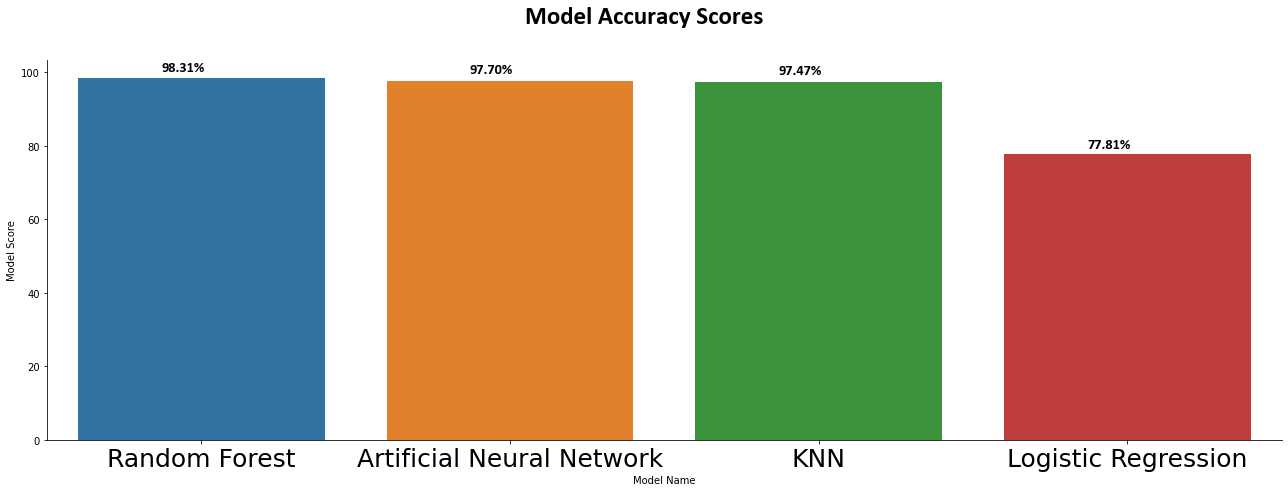

In [78]:
g = sns.catplot(x='Model Name', y='Model Score', data=myalgorithmsdf,
                height=6, aspect=3, kind='bar', legend=True)
g.fig.suptitle('Model Accuracy Scores', size=25, y=1.1, **hfont)
ax = g.facet_axis(0,0)
ax.tick_params(axis='x', which='major', labelsize=25)
for p in ax.patches:
    ax.text(p.get_x() + 0.27,
            p.get_height() * 1.02,
           '{0:.2f}%'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='x-large', **hfont)
plt.savefig("Visualizations\Models.png")
plt.show()

## SHAP

In [79]:
# Create a object of our model Random Forest
model = RandomForestClassifier(n_estimators= 100,n_jobs= 1,random_state= 1)
# Call a fit method on your model with your X_train and y_train
model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=1, random_state=1)

In [80]:
import shap

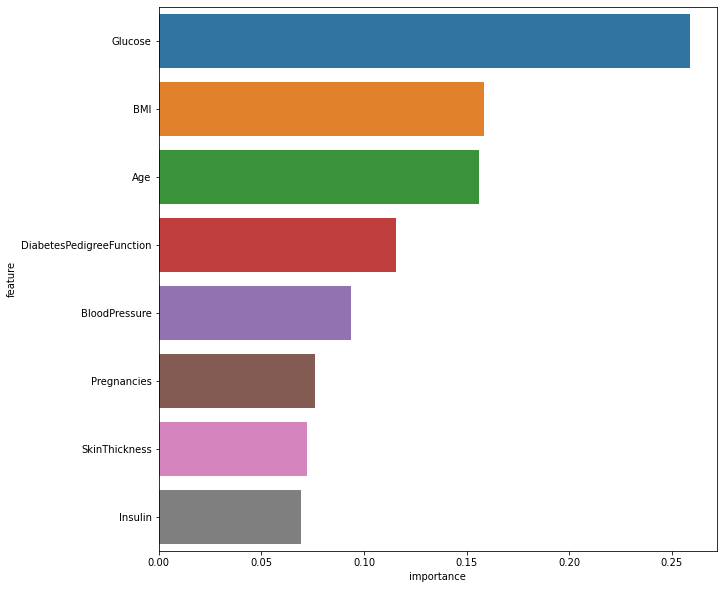

In [81]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values('importance',ascending=False).reset_index()
plt.figure(figsize=(10,10))
sns.barplot(x='importance',y='feature',data=feature_importance_df[:15])
plt.savefig("Visualizations\ShapFutureImportance.png")
plt.show()